In [172]:
import json
import numpy as np
import pandas as pd
from os import path
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

In [173]:
stories_json = []
with open('./output_storiesv2.json', 'r') as f:
    stories_json = stories_json + json.loads(f.read())

print(len(stories_json))
print(stories_json[1].keys())

407
dict_keys(['index', 'title', 'broadcasting_date', 'abstracts_list'])


In [174]:
stories_df = pd.DataFrame(stories_json)
stories_df["abstract_joined"] = stories_df["abstracts_list"].str.join(" ")
stories_df.head()

,index,title,broadcasting_date,abstracts_list,abstract_joined
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013年3月15日,[ 何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいな...,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013年4月12日,[ ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。この...,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],2013年4月26日,[ スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとする...,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...
3,0328,「ひるねは天国で」「どくさいスイッチ」[2013年5月3日放送],2013年5月3日,[ のび太とドラえもんが部屋で昼寝をしていると、突然大きな音が聞こえてくる。となりの家が改築...,のび太とドラえもんが部屋で昼寝をしていると、突然大きな音が聞こえてくる。となりの家が改築工...
4,0329,「インスタントママ」「狙われたジャイアン」[2013年5月10日放送],2013年5月10日,[ そうじにせんたく、町内会の会合と毎日大忙しのママが、「体がもうひとつほしい」とため息をつ...,そうじにせんたく、町内会の会合と毎日大忙しのママが、「体がもうひとつほしい」とため息をつい...


In [175]:
stories_df['broadcasting_date'] = stories_df['broadcasting_date'].apply(lambda d: datetime.strptime(d, '%Y年%m月%d日'))

In [176]:
t = MeCab.Tagger('-d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')
def mecab_tokenizer(text):
    parsed_lines = t.parse(text).split("\n")[:-2]
    surfaces = [l.split('\t')[0] for l in parsed_lines]
    features = [l.split('\t')[1] for l in parsed_lines]
    # 原型を取得
    bases = [f.split(',')[6] for f in features]
    # 品詞を取得
    pos = [f.split(',')[0] for f in features]

    # 各単語を原型に変換する
    token_list = [b if b != '*' else s for s, b in zip(surfaces, bases)]
    # 瀕死を絞り込み
    target_pos = ["名詞"]
    token_list = [t for t, p in zip(token_list, pos) if p in target_pos]
    # アルファベットを小文字に統一
    token_list = [t.lower() for t in token_list]

    return [ text for text in filter(lambda x: not x.isascii(), token_list)]

In [177]:
# ストーリーが取得できたものに絞る
stories_df = stories_df[stories_df['abstract_joined'].str.len() > 0] 
stories_df['abstract_joined_tokenize'] = stories_df['abstract_joined'].apply(mecab_tokenizer)
stories_df.head()

,index,title,broadcasting_date,abstracts_list,abstract_joined,abstract_joined_tokenize
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,[ 何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいな...,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...,"[何, のび太, 魔法, 魔法, 便利, ちがい, もしもボックス, 現実, 世界, 魔法,..."
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,[ ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。この...,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...,"[朝, 寝坊, のび太, ドラえもん, 爆発, コショウ, コショウ, 行き先, そば, 人..."
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],2013-04-26,[ スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとする...,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...,"[スネ夫, ハワイ旅行, じまん, のび太, 自分, ハワイ, ママ, 給料日, 前, お金..."
3,0328,「ひるねは天国で」「どくさいスイッチ」[2013年5月3日放送],2013-05-03,[ のび太とドラえもんが部屋で昼寝をしていると、突然大きな音が聞こえてくる。となりの家が改築...,のび太とドラえもんが部屋で昼寝をしていると、突然大きな音が聞こえてくる。となりの家が改築工...,"[のび太, ドラえもん, 部屋, 昼寝, 音, となり, 家, 改築, 工事, の, しずか..."
4,0329,「インスタントママ」「狙われたジャイアン」[2013年5月10日放送],2013-05-10,[ そうじにせんたく、町内会の会合と毎日大忙しのママが、「体がもうひとつほしい」とため息をつ...,そうじにせんたく、町内会の会合と毎日大忙しのママが、「体がもうひとつほしい」とため息をつい...,"[そうじ, せんたく, 町内会, 会合, 毎日, 大忙し, ママ, 体, ひとつ, ため息,..."


In [178]:
stories_df["doraemon_flag"] = stories_df["abstract_joined_tokenize"].apply(lambda x: "ドラえもん" in x)
stories_df["nobita_flag"] = stories_df["abstract_joined_tokenize"].apply(lambda x: "のび太" in x)
stories_df["sizuka_flag"] = stories_df["abstract_joined_tokenize"].apply(lambda x: "しずか" in x or "しずかちゃん" in x)
stories_df["gian_flag"] = stories_df["abstract_joined_tokenize"].apply(lambda x: "ジャイアン" in x)
stories_df["suneo_flag"] = stories_df["abstract_joined_tokenize"].apply(lambda x: "スネ夫" in x)
stories_df["dekisugi_flag"] = stories_df["abstract_joined_tokenize"].apply(lambda x: "出木杉" in x)

stories_df.head()

,index,title,broadcasting_date,abstracts_list,abstract_joined,abstract_joined_tokenize,doraemon_flag,nobita_flag,sizuka_flag,gian_flag,suneo_flag,dekisugi_flag
0,0325,春だ！映画だ！３時間アニメ祭り\r\n「映画ドラえもん のび太の新魔界大冒険～７人の魔法使い...,2013-03-15,[ 何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいな...,何をやってもうまくいかないのび太は、「魔法（まほう）が使えたら便利で楽しくなるにちがいない...,"[何, のび太, 魔法, 魔法, 便利, ちがい, もしもボックス, 現実, 世界, 魔法,...",True,True,True,True,True,False
1,0326,「ばくはつコショウ」「何が何でもお花見を」[2013年4月12日放送],2013-04-12,[ ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。この...,ある朝、ねぼうしたのび太に泣きつかれたドラえもんは、『ばくはつコショウ』を取り出す。このコ...,"[朝, 寝坊, のび太, ドラえもん, 爆発, コショウ, コショウ, 行き先, そば, 人...",True,True,True,True,False,False
2,0327,「やりクリしてハワイ旅行」「しずかちゃんのはごろも」[2013年4月26日放送],2013-04-26,[ スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとする...,スネ夫からハワイ旅行をじまんされたのび太は、自分もハワイに行きたいとママにたのもうとするが...,"[スネ夫, ハワイ旅行, じまん, のび太, 自分, ハワイ, ママ, 給料日, 前, お金...",True,True,True,False,True,False
3,0328,「ひるねは天国で」「どくさいスイッチ」[2013年5月3日放送],2013-05-03,[ のび太とドラえもんが部屋で昼寝をしていると、突然大きな音が聞こえてくる。となりの家が改築...,のび太とドラえもんが部屋で昼寝をしていると、突然大きな音が聞こえてくる。となりの家が改築工...,"[のび太, ドラえもん, 部屋, 昼寝, 音, となり, 家, 改築, 工事, の, しずか...",True,True,True,True,True,False
4,0329,「インスタントママ」「狙われたジャイアン」[2013年5月10日放送],2013-05-10,[ そうじにせんたく、町内会の会合と毎日大忙しのママが、「体がもうひとつほしい」とため息をつ...,そうじにせんたく、町内会の会合と毎日大忙しのママが、「体がもうひとつほしい」とため息をつい...,"[そうじ, せんたく, 町内会, 会合, 毎日, 大忙し, ママ, 体, ひとつ, ため息,...",True,True,False,True,True,False


<AxesSubplot:xlabel='broadcasting_date', ylabel='sizuka_flag'>

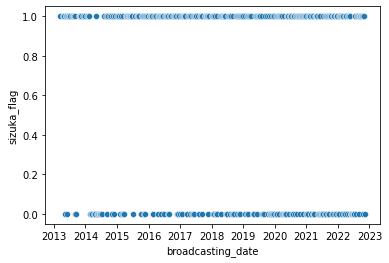

In [179]:
sns.scatterplot(data=stories_df, x="broadcasting_date", y="sizuka_flag")


In [180]:
# 年ごとの割合を算出
grouped_stories_sum_df = stories_df['index'].groupby([stories_df['broadcasting_date'].dt.year]).count()
grouped_stories_sum_df = pd.DataFrame(grouped_stories_sum_df)
grouped_stories_sum_df.reset_index(inplace=True)
grouped_stories_sum_df.rename(columns={
    'index': 'total_stories_count',
    'broadcasting_date': 'broadcasting_year'
}, inplace=True)
grouped_stories_sum_df.head()

,broadcasting_year,total_stories_count
0,2013,28
1,2014,35
2,2015,39
3,2016,41
4,2017,38


In [181]:
grouped_df = stories_df.groupby([stories_df['broadcasting_date'].dt.year]).sum()
grouped_df.reset_index(inplace=True)
melt_df = pd.melt(grouped_df, id_vars=['broadcasting_date'], value_vars=['doraemon_flag', 'nobita_flag', 'sizuka_flag', 'gian_flag', 'suneo_flag', 'dekisugi_flag'])
melt_df.rename(columns={'broadcasting_date': 'broadcasting_year'}, inplace=True)
melt_df.head()

,broadcasting_year,variable,value
0,2013,doraemon_flag,28
1,2014,doraemon_flag,34
2,2015,doraemon_flag,39
3,2016,doraemon_flag,41
4,2017,doraemon_flag,38


In [183]:
joined_stories_df = melt_df.merge(grouped_stories_sum_df, on='broadcasting_year', how='left')
joined_stories_df['percentage'] = joined_stories_df['value'] / joined_stories_df['total_stories_count']
joined_stories_df.head()


,broadcasting_year,variable,value,total_stories_count,percentage
0,2013,doraemon_flag,28,28,1.000000
1,2014,doraemon_flag,34,35,0.971429
2,2015,doraemon_flag,39,39,1.000000
3,2016,doraemon_flag,41,41,1.000000
4,2017,doraemon_flag,38,38,1.000000


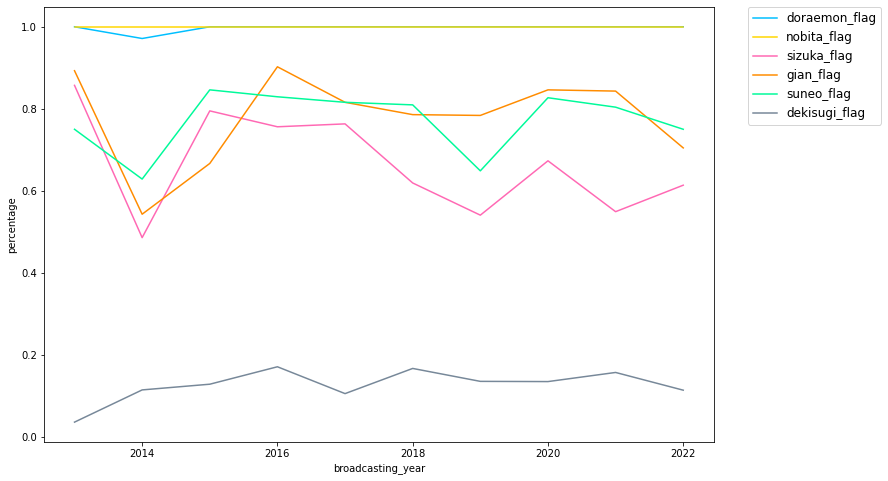

In [185]:
colors = ['#00bfff', '#ffd700', '#ff69b4', '#ff8c00', '#00fa9a', '#778899']

plt.figure(figsize=(12,8))
sns.lineplot(x='broadcasting_year', y='percentage', hue='variable', data=joined_stories_df, palette=sns.color_palette(colors))
plt.legend(bbox_to_anchor=(1.25, 1.0), loc='upper right', borderaxespad=0, fontsize=12)
